In [9]:
print(norm.cdf(0, 0, 1))
print(norm.cdf(-1, 0, 1))

0.5
0.158655253931


In [1]:
import numpy as np
import math
from matplotlib import pyplot as plt
import scipy.stats as sct

from scipy.stats import expon
from scipy.stats import uniform
from scipy.stats import norm
from scipy.stats import binom

from sklearn import linear_model

for comparison purposes: without unbiased estimator

In [37]:
def claims(epsilon, delta, mu, sigma, n, p, burn_in):
    
    z = sct.norm.ppf(1 - delta / 2)       # 1 - delta / 2 quantile of N(0, 1)
    confidence_interval = float('Inf')    # start with an infinity confident interval
    running_mean = 0                      # first is null estimator, second corresponds to using control covariate
    running_2moment = 0                   # same as above
    N = 0                                 # count of number of paths sampled
    Max_experiment = burn_in*10
    res = []
    while (N < burn_in or confidence_interval >= epsilon) and N < Max_experiment:   
        s = binom.rvs(n, p)
        if s > 0:
            Z = norm.rvs(0,1, size=s)
            X = sum(np.exp(1)**(mu + sigma*Z))
            res.append(X)
        else:
            X = 0
        
        running_mean = (running_mean * N + X) / (N + 1)
        running_2moment = (running_2moment * N + pow(X, 2)) / (N + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2) )
        N = N + 1
        confidence_interval = z * sample_std / (math.sqrt(N))
    
    CI = [running_mean - confidence_interval, running_mean + confidence_interval]
    plt.hist(res, bins=N)
    
    print('Generate', N, "samples \n")
    return CI

Generate 10000 samples 



[4.3570970728652378, 4.622921688891064]

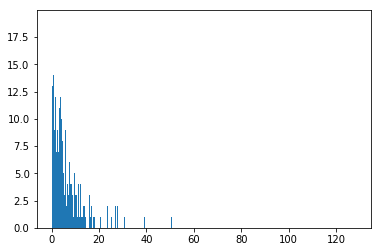

In [39]:
claims(.0625, .0625, 1, 1, 100, .01, 1000)

In [35]:
def sampler(n, p, N, mu, sigma):
    X = np.zeros(N)
    for i in range(N):
        s = binom.rvs(n, p)
        Z = norm.rvs(0,1, size=s)
        X[i] = sum(np.exp(1)**(mu + sigma*Z))
    return X

In [46]:
test = sampler(100, 0.01, 1000,1 , 1)
len(test[1::2])

500

unbiased estimator 

In [51]:
def new_claims(n, p, mu, sigma):
    """
    Since each estimator takes about 2^(n_0+2) samples, we actually generate
    2^(n_0+2)*num_sample many iid X's

    Sample call:
        Example_1_lecture16(10, 0.05, 1000, 1)
    """
    # Do the experiment
    # experiment variables
    
    n_0 = 10
    delta = 0.0625
    num_sample = 1000
    burn_in = 1
    
    z = sct.norm.ppf(1 - delta/2)  # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow(2, -1.5)     # optimal success rate for the geometric of N

    confidence_interval = float('inf')
    running_mean = 0
    running_2moment = 0
    num_estimator = 0     #count of number of estimators generated

    CIs = np.zeros((1, num_sample))
    estimation = np.zeros((1, num_sample))

    while num_estimator < num_sample:
        N = np.random.geometric(p=r_star)

        samples = sampler(n, p, pow(2,N+n_0+1), mu, sigma)
        samples_odd = samples[0::2]
        samples_even = samples[1::2]
        samples_n_0 = samples[0:pow(2,n_0)]

        theta_N = np.mean(samples)
        theta_N_odd = np.mean(samples_odd)
        theta_N_even = np.mean(samples_even)
        theta_n_0 = np.mean(samples_n_0)

        X_star = (theta_N - (theta_N_odd + theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + theta_n_0

        running_mean = (running_mean * num_estimator + X_star) / (num_estimator + 1)
        running_2moment = (running_2moment * num_estimator + pow(X_star, 2)) / (num_estimator + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2))
        num_estimator = num_estimator + 1
        confidence_interval = z * sample_std / (math.sqrt(num_estimator))
        estimation[:,num_estimator-1] = running_mean
        CIs[:,num_estimator-1] = confidence_interval

    lower = estimation - CIs
    upper = estimation + CIs

    print('Generate', num_estimator , 'samples \n')
    n_range = np.arange(burn_in-1, num_sample)
    plt.plot(n_range, estimation[0,n_range], label='estimation')
    plt.plot(n_range, lower[0,n_range],  label='lower CI')
    plt.plot(n_range, upper[0,n_range], label='upper CI')
    plt.legend(loc='upper right')
    plt.show()

    return running_mean, confidence_interval

Generate 1000 samples 



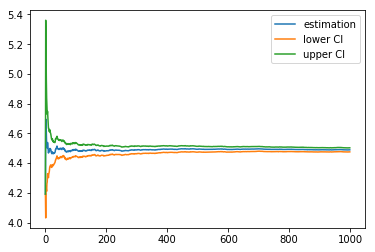

In [53]:
mean, CI = new_claims(100, 0.01, 1, 1)

In [71]:
print('Confidence Interval: ',
      [mean.item(-1)-(CI.item(-1)-mean.item(-1)), 
      mean.item(-1)+(CI.item(-1)-mean.item(-1))])

Confidence Interval:  [4.44831832016289, 4.502861490271506]


In [4]:
def simulator(epsilon, delta, burn_in):
    
    z = sct.norm.ppf(1 - delta / 2)       # 1 - delta / 2 quantile of N(0, 1)
    confidence_interval = float('Inf')    # start with an infinity confident interval
    running_mean = 0                      # first is null estimator, second corresponds to using control covariate
    running_2moment = 0                   # same as above
    N = 0                                 # count of number of paths sampled
    Max_experiment = burn_in*10
    EW, ET = [], []
    
    while (N < burn_in or confidence_interval >= epsilon) and N < Max_experiment:   
        w, v = np.zeros(1), uniform.rvs(0)
        w[0], T = v, 1      ##########################
        Z = w[0]           #initialize first arrival#
        while Z > 0:      ##########################
            v, tau = uniform.rvs(0), uniform.rvs(1)
            Z = max(0, w[T-1] + v - tau)
            T += 1
            w = np.append(w, Z)
        EW.append(np.sum(w))
        ET.append(T)
        eq = np.mean(EW)/np.mean(ET)
        
        running_mean = (running_mean * N + eq) / (N + 1)
        running_2moment = (running_2moment * N + pow(eq, 2)) / (N + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2) )
        N = N + 1
        confidence_interval = z * sample_std / (math.sqrt(N))
    
    CI = [running_mean - confidence_interval, running_mean + confidence_interval]
    plt.hist(EW, bins=N)
    
    print('Generate', N, "samples \n")
    return CI

Generate 10000 samples 



[0.24849002698142958, 0.24865877298969535]

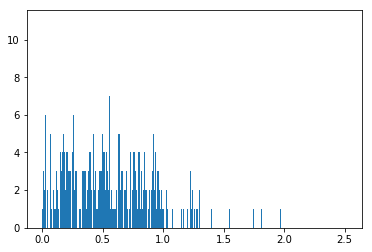

In [40]:
simulator(.05, .05, 10000)

In [72]:
def queuer(N):
    Ws, Ts = np.zeros(N), np.zeros(N)
    for i in range(N):
        w, v = np.zeros(1), uniform.rvs(0)
        w[0], T = v, 1      ##########################
        Z = w[0]           #initialize first arrival#
        while Z > 0:      ##########################
            v, tau = uniform.rvs(0), uniform.rvs(1)
            Z = max(0, w[T-1] + v - tau)
            T += 1
            w = np.append(w, Z)
        Ws[i] = np.sum(w)
        Ts[i] = T
    return Ws, Ts

In [74]:
def new_simulator():
    """
    Since each estimator takes about 2^(n_0+2) samples, we actually generate
    2^(n_0+2)*num_sample many iid X's

    Sample call:
        Example_1_lecture16(10, 0.05, 1000, 1)
    """
    # Do the experiment
    # experiment variables
    
    n_0 = 10
    delta = 0.05
    num_sample = 1000
    burn_in = 1
    
    z = sct.norm.ppf(1 - delta/2)  # 1 - delta/2 quantile of N(0, 1)
    r_star = 1 - pow(2, -1.5)     # optimal success rate for the geometric of N

    confidence_interval = float('inf')
    running_mean = 0
    running_2moment = 0
    num_estimator = 0     #count of number of estimators generated

    CIs = np.zeros((1, num_sample))
    estimation = np.zeros((1, num_sample))

    while num_estimator < num_sample:
        N = np.random.geometric(p=r_star)

        w_samples, t_samples = queuer(pow(2,N+n_0+1))
        w_samples_odd, t_samples_odd = w_samples[0::2], t_samples[0::2]
        w_samples_even, t_samples_even = w_samples[1::2], t_samples[1::2]
        w_samples_n_0, t_samples_n_0 = w_samples[0:pow(2,n_0)], t_samples[0:pow(2,n_0)]

        theta_N = np.mean(w_samples)/np.mean(t_samples)
        theta_N_odd = np.mean(w_samples_odd)/np.mean(t_samples_odd)
        theta_N_even = np.mean(w_samples_even)/np.mean(t_samples_even)
        theta_n_0 = np.mean(w_samples_n_0)/np.mean(t_samples_n_0)

        X_star = (theta_N - (theta_N_odd + theta_N_even) / 2) / sct.geom(r_star).pmf(N+1) + theta_n_0

        running_mean = (running_mean * num_estimator + X_star) / (num_estimator + 1)
        running_2moment = (running_2moment * num_estimator + pow(X_star, 2)) / (num_estimator + 1)
        sample_std = math.sqrt(running_2moment - pow(running_mean, 2))
        num_estimator = num_estimator + 1
        confidence_interval = z * sample_std / (math.sqrt(num_estimator))
        estimation[:,num_estimator-1] = running_mean
        CIs[:,num_estimator-1] = confidence_interval

    lower = estimation - CIs
    upper = estimation + CIs

    print('Generate', num_estimator , 'samples \n')
    n_range = np.arange(burn_in-1, num_sample)
    plt.plot(n_range, estimation[0,n_range], label='estimation')
    plt.plot(n_range, lower[0,n_range],  label='lower CI')
    plt.plot(n_range, upper[0,n_range], label='upper CI')
    plt.legend(loc='upper right')
    plt.show()

    return running_mean, confidence_interval

Generate 1000 samples 



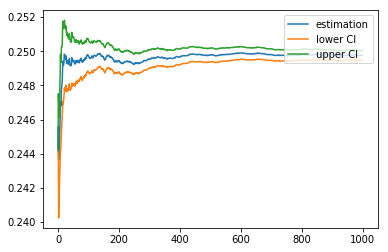

In [76]:
mean, CI = new_simulator()

In [77]:
print('Confidence Interval: ',[mean-CI, mean+CI])

Confidence Interval:  [0.24947478502487294, 0.25004140830292637]


To generate an unbiased estimator, we first pick $n_0=10$ and sample $N=Geo(p)+n_0-1$ with $p=1-(1/2)^{3/2}$ for convenience

We generate independent $X$s and then we generate $2^{N+1}$ samples of $Y$ from distribution $P(Y|X)$; we can call this $Z(X)$ such $E[Z(X)] =  g(E[Y(x)]$

Then we split the samples into even and odd, outputting $Z = \frac{\bar{Z}_{2^{N+1}} - 1/2(\bar{Z}^{odd}_{2^N}+ \bar{Z}^{even}_{2^N})}{p(N)} + \bar{Z}_{2^{n_0}}$

We repeat this process until our error threshold is hit and compute the expectation $E[Z] = E[g(E[X|Y])]= \alpha$

the above shows the tower property at work: $\alpha = E[g(E[Y |X])] = E[Z]$

but this also applies with variance (law of total variance): $Var(Y) = E[Var(Y|X)] + Var(E[Y|X])$

therefore the same logic that applies in randomized MLMC with unconditional distribution applies in the same context as that of a conditional one

$g(\bar{Y}_{2^{n+1}})=g(\mu)+g_0(\mu) (\bar{Y}_{2^{n+1}}-\mu)+\frac{g''η_{n+1}}{2}(\bar{Y}_{2^{n+1}}-\mu)2$

w/ even/odds

$g(\bar{Y^{even}}_{2^{n}})=g(\mu)+g_0(\mu) (\bar{Y^{even}}_{2^{n}}-\mu)+\frac{g''η^{even}_{n}}{2}(\bar{Y^{even}}_{2^{n}}-\mu)2$

$g(\bar{Y^{odd}}_{2^{n}})=g(\mu)+g_0(\mu) (\bar{Y^{odd}}_{2^{n}}-\mu)+\frac{g''η^{odd}_{n}}{2}(\bar{Y^{odd}}_{2^{n}}-\mu)2$

condensed

$\frac{g''η_{n+1}}{2} (\bar{Y}_{2^{n+1}}-μ)^2 - \frac{g''(η^{even}_n)}{4}(\bar{Y}^{even}_{2n}-μ)^2 - \frac{g''(η^{odd}_n)}{4}(\bar{Y}^{odd}_{2n}-μ)^2$

by CLT

$E[[g(Y_{2^{n+1}}) - \frac{g(Y^{even}_{2^{n}}) + g(Y^{odd}_{2^{n}})}{2}]^2] \leq c \frac{1}{2^{2n}}$

so

$E[[g(Y_{2^{n+1}}) - \frac{g(Y^{even}_{2^{n}}) + g(Y^{odd}_{2^{n}})}{p(n)}]^2]$

$\leq \sum_{n=n_0}^{\infty}c \frac{1}{2^{2n}p(n)}$

additionally, given that our estimator has finite variance, we can note that given CLT, our estimator $Y^*$ converges at a rate $c^{-\frac{1}{2}}$ due to $p=1-(1/2)^{3/2}$